In [40]:
from sklearn.model_selection import train_test_split, KFold
import sys
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
from common import *
from create_matrix import *
import random
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
# initialization
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014
case = 2
num_home_factor = 3
num_season_factor = 3
source = 'Austin'
target = 'SanDiego'
constant_use = 'True'
start = 1
stop = 13
train_percentage = 50
validation_percentage = 10
test_percentage = 40
T_constant = np.ones(12).reshape(-1, 1)

In [42]:
source_df, source_dfc, source_tensor, source_static = create_region_df_dfc_static(source, year, start, stop)
target_df, target_dfc, target_tensor, target_static = create_region_df_dfc_static(target, year, start, stop)

num_samples = len(source_df)
index_list = np.arange(num_samples)
train_loc, validate_test_loc = train_test_split(index_list, train_size=train_percentage/100.0, random_state=0)
validate_loc, test_loc = train_test_split(validate_test_loc, train_size=2*validation_percentage/100.0, random_state=0)

train_df = source_df.loc[train_loc]
validate_df = source_df.loc[validate_loc]
test_df = source_df.loc[test_loc]

In [43]:
test_df = source_df.iloc[[0]]
train_df = source_df.drop(source_df.index[[0]])
train_df.index

Int64Index([  26,   48,   59,   68,   77,   86,   93,   94,  101,  114,
            ...
            9933, 9935, 9936, 9937, 9938, 9939, 9942, 9971, 9981, 9982],
           dtype='int64', length=532)

In [121]:
test_size = 10
num_iterations = 10
weight_matrices = {}
pred_train = {}
pred = {}
error = {}
H_history = {}
test_index = {}

for i in range(test_size):
    pred_train[i] = {}
    pred[i] = {}
    error[i] = {}
    H_history[i] = {}
    for iters in range(num_iterations):
        pred_train[i][iters] = {}
        pred[i][iters] = {}
        error[i][iters] = {}
        for appliance in APPLIANCES_ORDER:
            pred_train[i][iters][appliance] = []
            pred[i][iters][appliance] = []
            error[i][iters][appliance] = []
pred_test = {}
for iters in range(num_iterations):
    pred_test[iters] = {}
    for appliance in APPLIANCES_ORDER:
        pred_test[iters][appliance] = []
        
# for each test home
for i in range(test_size):
    
    test_df = source_df.iloc[[i]]
    train_df = source_df.drop(source_df.index[[i]])
    
    train_index = train_df.index
    test_index[i] = test_df.index
    
    df = pd.concat([test_df, train_df])
    tensor = get_tensor(df, 1, 13)
    
    weight_matrices[i] = {}
    train_weight = np.ones(tensor.shape)
        
    print "test: ", i
    for iters in range(num_iterations):
        
        print 'iteration: ', iters
        weight_matrices[i][iters] = train_weight 
        tensor_copy = tensor.copy()
        tensor_copy[0, 1:, :] = np.NaN
        
        H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                               None,
                                                              num_home_factor,
                                                              num_season_factor,
                                                             train_weight,
                                                              num_iter=2000,
                                                              lr=0.1, dis=True,
                                                              lam=0,
                                                              T_known=T_constant)
        
        # get the similarity between home factors
        similarities = cosine_similarity(H)
        sim = similarities[0]
        
        # get the prediction error of training homes
        HAT = multiply_case(H, A, T, case)
        for appliance in APPLIANCES_ORDER:
            pred_train[i][iters][appliance].append(pd.DataFrame(HAT[1:, appliance_index[appliance], :], index=train_index))
            pred[i][iters][appliance].append(pd.DataFrame([HAT[0, appliance_index[appliance], :]], index=test_index[i]))
            pred_test[iters][appliance].append(pd.DataFrame([HAT[0, appliance_index[appliance], :]], index=test_index[i]))
       
        # compute the appliance prediction error for each training homes
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred_train[i][iters][appliance]).loc[train_index]
            if appliance=="hvac":
                error[i][iters][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[3]
            else:   
                error[i][iters][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[3]
        
        # compute the average appliance error for each home
        error_avg = {}
        for appliance in APPLIANCES_ORDER[1:]:

            if appliance == 'hvac':
                start, end = 5, 11
            else:
                start, end = 1, 13

            error_home = pd.concat([error[i][iters][appliance][appliance + "_{}".format(start)], 
                               error[i][iters][appliance][appliance + "_{}".format(start+1)]],axis=1)

            for k in range(start+2, end):
                error_home = pd.concat([error_home, error[i][iters][appliance][appliance + "_{}".format(k)]], axis=1)
            app = np.sqrt((error_home**2).mean(axis=1))
            error_avg[appliance] = app
        error_overall = (pd.DataFrame(error_avg).fillna(0)*pd.Series(contri['Austin'])).sum(axis=1)

        train_confidence = 1/pd.DataFrame(error_overall).reindex(train_index).T.as_matrix()
        
        sim = (sim - sim.min())/(sim.max() - sim.min())
        train_weight = np.repeat(sim.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
        
        H_history[i][iters] = H

test:  0
iteration:  0
498.754303546
140.193545729
101.452697151
88.587590914
iteration:  1
398.435109095
111.076387488
81.2239762859
72.2533244427
iteration:  2
393.924280692
109.672000398
79.8574045782
71.3295811578
iteration:  3
409.650781423
114.375225813
83.167424279
73.7221743474
iteration:  4
404.796589053
112.92702298
82.266501261
73.0782899799
iteration:  5
407.785798892
113.696262012
82.7619523178
73.4919379617
iteration:  6
406.380190011
113.398528579
82.5858476749
73.3243536632
iteration:  7
407.674279668
113.670574176
82.7457673591
73.476621746
iteration:  8
406.794056689
113.529292502
82.6787650041
73.3922864336
iteration:  9
407.5944797
113.644306214
82.7296668197
73.4648088876
test:  1
iteration:  0
499.018583043
140.226563859
101.544431236
88.5702829357
iteration:  1
459.080294379
125.692875846
90.9529264101
80.3686883704
iteration:  2
450.08385716
122.978826635
89.0967386247
78.7995224499
iteration:  3
457.732787962
125.601461917
90.9806968604
80.4717914335
iteration:

In [110]:
test_index = {}
for i in range(test_size):
    
    test_df = source_df.iloc[[i]]
    train_df = source_df.drop(source_df.index[[i]])
    
    train_index = train_df.index
    test_index[i] = test_df.index

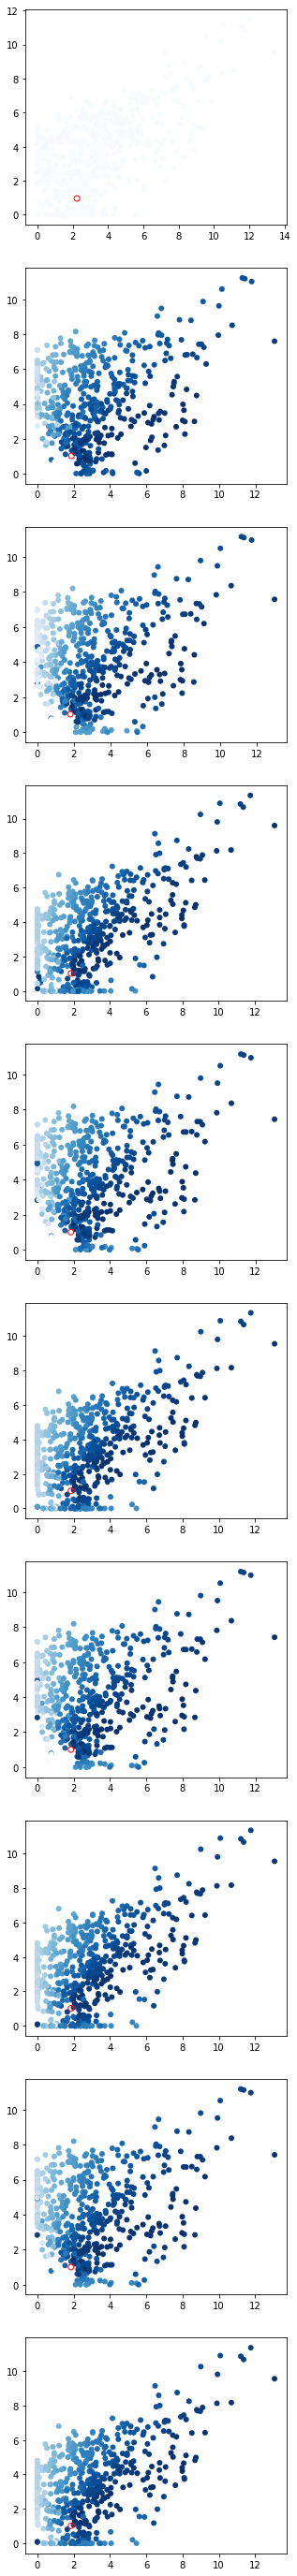

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

for iteration in range(0, num_iterations):
    X = H_history[0][iteration]
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
   
    weight = weight_matrices[0][iteration][:].mean(axis=1).mean(axis=1)
    axes[iteration].scatter(X[1:, x1], X[1:, x2], c=weight[1:], cmap='Blues', lw=0)
    axes[iteration].scatter(X[0, x1], X[0, x2], color='red', marker='o', facecolors='none')

In [111]:
out= {}

for i in range(test_size):
    out[i] = {}
    for iteration in range(num_iterations):
        print iteration
        out[i][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[i][iteration][appliance]).loc[test_index[i]]
            print appliance
            try:
                if appliance=="hvac":
                    out[i][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
                else:   
                    out[i][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]
            except Exception, e:
                print (e)

0
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
1
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
3
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
Found array with 0 sample(s) (shape=(0,)) while a mi

8
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
9
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
wm
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
oven
0
hvac
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
fridge
mw
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
1
hvac
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
fridge
mw
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2
hvac
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
fridge
mw
dw
wm
oven
Found array with 0 sampl

fridge
mw
dw
wm
oven
1
hvac
fridge
mw
dw
wm
oven
2
hvac
fridge
mw
dw
wm
oven
3
hvac
fridge
mw
dw
wm
oven
4
hvac
fridge
mw
dw
wm
oven
5
hvac
fridge
mw
dw
wm
oven
6
hvac
fridge
mw
dw
wm
oven
7
hvac
fridge
mw
dw
wm
oven
8
hvac
fridge
mw
dw
wm
oven
9
hvac
fridge
mw
dw
wm
oven
0
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
1
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
2
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
3
hvac
fridge
mw
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
dw
wm
oven
Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
4
hvac


In [102]:
pd.DataFrame(out[i])

,0,1,2,3,4,5,6,7,8,9
dw,0.735963,0.725423,0.587635,0.697322,0.705271,0.703582,0.904390,0.719120,0.702053,0.701044
fridge,9.232567,8.900019,9.137855,9.292352,9.084330,9.169922,9.141454,9.157868,9.145104,9.153191
hvac,23.046462,21.221679,21.292946,21.293536,21.303473,21.204342,21.310368,21.209262,21.316353,21.206925


In [118]:
pd.DataFrame(out[i])

,0,1,2,3,4,5,6,7,8,9
dw,0.646910,0.658555,0.654797,0.660295,0.655203,0.657805,0.655495,0.657702,0.654621,0.658985
fridge,1.054394,0.678804,0.602030,0.660371,0.644639,0.653971,0.645697,0.654369,0.645479,0.654344
hvac,9.543695,10.326045,10.617933,10.532384,10.511749,10.547327,10.510590,10.546898,10.511351,10.547836
mw,1.167855,1.231632,1.228922,1.228293,1.223871,1.228737,1.223762,1.228282,1.223954,1.228207
wm,0.180499,0.195691,0.196145,0.195775,0.195237,0.195796,0.195081,0.195747,0.195144,0.195728


no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt
no gt


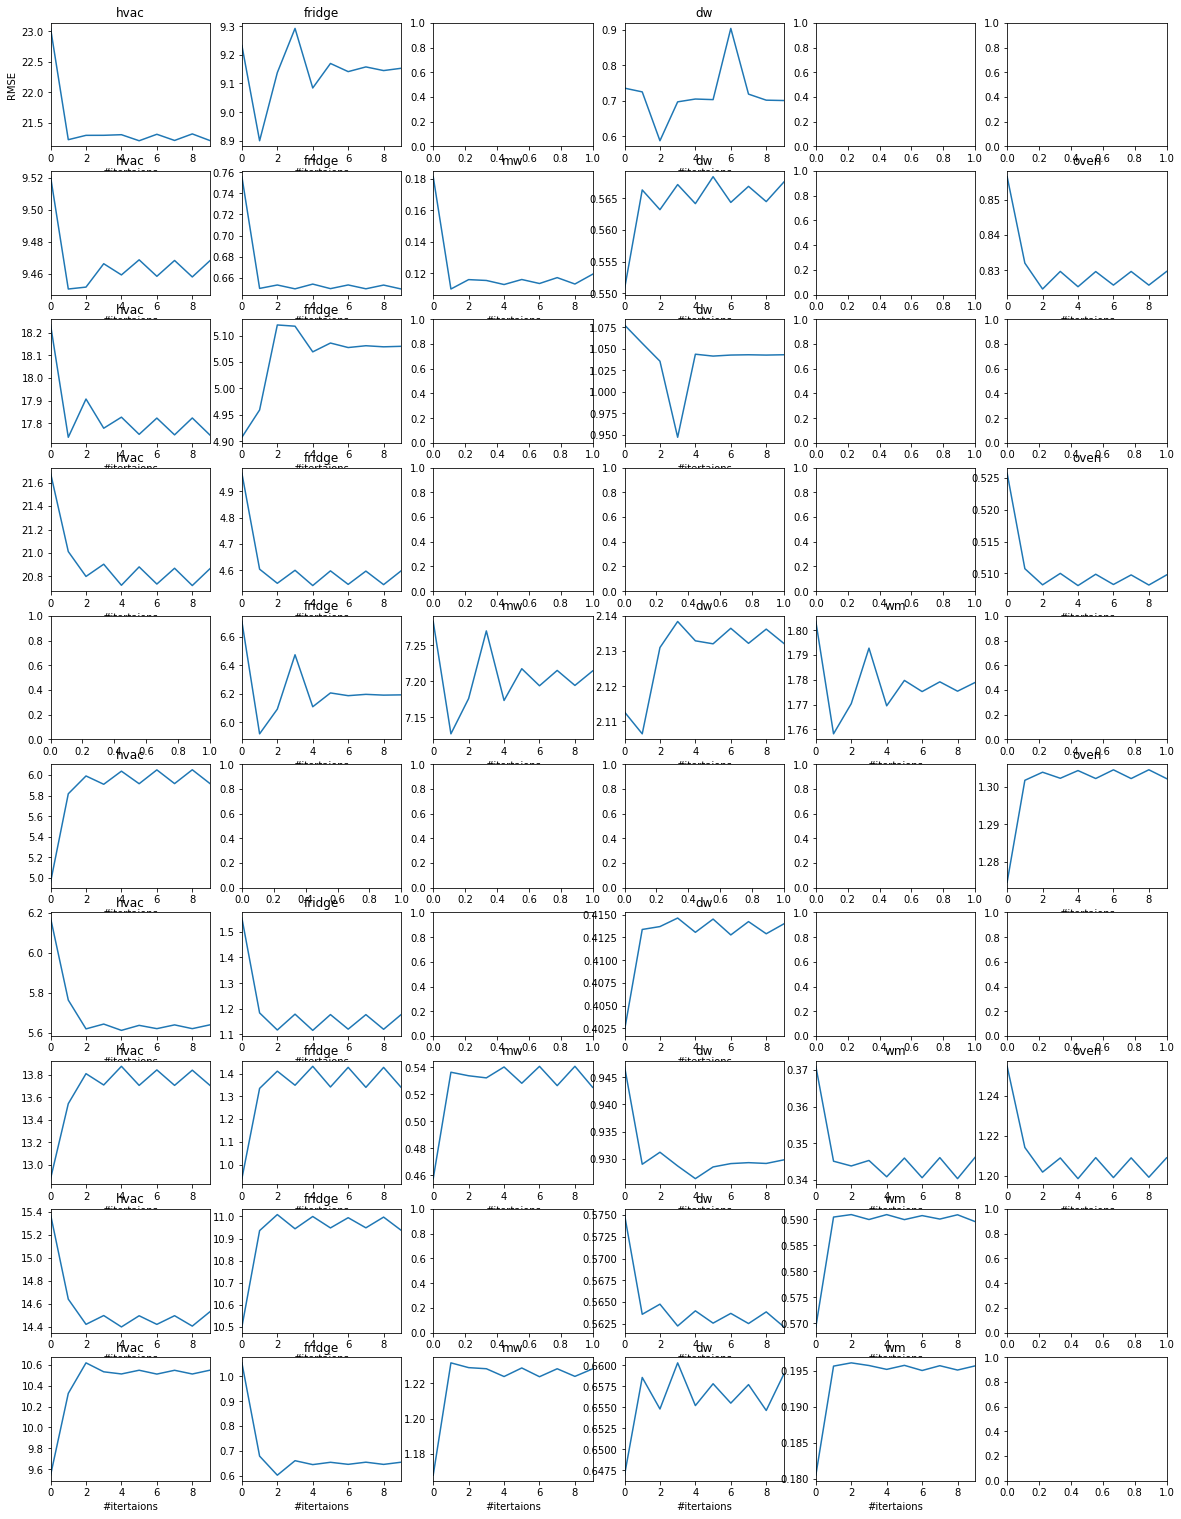

In [115]:
fig, axes = plt.subplots(nrows=test_size, ncols=6, figsize=(20, 30))
ax = axes.flatten()
count = 0

for i in range(test_size):
    mean_out = pd.DataFrame(out[i])
    for appliance in APPLIANCES_ORDER[1:]:
        try:
            mean_out.T[appliance].plot(ax = ax[count], title=appliance)

            ax[count].set_xlabel("#itertaions")
            count += 1
        except Exception, e:
            print "no gt"
            count += 1
ax[0].set_ylabel("RMSE")
# ax[count-1].legend(['with', 'without', 'app'], loc='center left')
# plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)
# plt.savefig("appliance-witherror-rmse.pdf", format='pdf')
